<a href="https://colab.research.google.com/github/jermwatt/meme_search/blob/main/meme_search_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# if running in collab pull repo and install requirements
# recommended: use a gpu runtime like e.g., T4
if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/jermwatt/meme_search.git
    %cd meme_search
    !pip install -r requirements.txt

# meme organization is hard

- i have a big folder of my most prized memes.  sits on my desktop.  most are screenshots with random names.

- my OS (mac) doesn't provide good searchability of these images. 

- so i'm forced to arrow through them whenever i need to find a good one.

- i want to be able to search through my memes faster - semantically via their text or visual content.

# lets build a meme search engine

- how do we create the foundation of the search engine?

- we want each image is indexed based on both its text (the text laid over the image) and a text description of its visual content.  and we want to make that text searchable.

- here's how we'll do it in 3 steps:

1.  **extract**: get text descriptions of each image, including ocr of any text on the image, using the kickass tiny vision-llm  [moondream](https://github.com/vikhyat/moondream)


2.  **embed**: window and embed each image's text description using a popular embedding model - [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)


3.  **index**: index the embeddings in an open source and local vector base [faiss database](https://github.com/facebookresearch/faiss) and references connecting the embeddings to their images in the greatest little db of all time - [sqlite](https://sqlite.org/)

---

- here's the collection of 9 meme's we'll use for testing.

- lets roll.


<style>
    #images {
    white-space: nowrap;
}
</style>
<div style="border: thin solid black">
<img src="./data/input/test_meme_1.jpg" width="25%">
<img src="./data/input/test_meme_2.jpg" width="25%">
<img src="./data/input/test_meme_3.jpg" width="25%">
<img src="./data/input/test_meme_4.jpg" width="25%">
<img src="./data/input/test_meme_5.jpg" width="25%">
<img src="./data/input/test_meme_6.jpg" width="25%">
<img src="./data/input/test_meme_7.jpg" width="25%">
<img src="./data/input/test_meme_8.jpg" width="25%">
<img src="./data/input/test_meme_9.jpg" width="25%">
</div>

</ul>


# 1.  extract

- a vision language model (vlm) takes in an image and text prompt, and outputs text

- they're used as baseline caption models often but - depending on how their trained / fine tuned - can be used for [other things as well]([larger list here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard)).  things like
    - question answering: asking questions about an image
    - optical character recognition (ocr): find text in an image
    - general object detection
    - ...

- we will [moondream](https://github.com/vikhyat/moondream), very powerful yet tiny model you can run locally.

- if you have decent hardware you can easily swap moondream out for a larger model of your choosing - like a [larger model similarly trained](https://github.com/clovaai/donut), or one fine tuned for particular task like ocr - see e.g., [kosmos](https://github.com/microsoft/unilm/tree/master/kosmos-2.5)

- below we use a lightly modified version of the basic moondream setup you can find on their repo.

- the function `prompt_moondream` takes in a path to an image and an input prompt, and returns the "answer" from the model.

- you can see we will use several libraries here like PIL and transformers - you can install everything you need here using the `requirements.txt` of this repo

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import transformers

transformers.logging.set_verbosity_error()


def prompt_moondream(img_path: str, prompt: str) -> str:
    # copied from moondream demo readme --> https://github.com/vikhyat/moondream/tree/main
    model_id = "vikhyatk/moondream2"
    revision = "2024-05-20"
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        revision=revision,
    )
    # INFO: uncomment if you have available gpu / using google collab (use a gpu runtime)
    # model.to('cuda')

    tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
    image = Image.open(img_path)
    enc_image = model.encode_image(image)
    moondream_response = model.answer_question(enc_image, prompt, tokenizer)
    return moondream_response

/Users/jeremywatt/Desktop/content_creation/meme_search/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- lets explore two prompts for getting detailed text descriptions of our memes

- the baseline prompt for captioning images with moondream is "Describe this image."

- we use this and process each of our images, showing the results below (using matplotlib).

- moondream's baseline "caption" prompt does a great job of providing both an accurate description of the content of the image, as well as "ocr"-ing the text laid on top of it.

In [2]:
# load in images from data/input/
import os

file_src = "data/input/"
img_paths = []
for x in os.listdir(file_src):
    if x.split(".")[-1] in ["jpg", "jpeg", "png"]:
        img_paths.append("data/input/" + x)
img_paths = sorted(img_paths)

# extract description of each image
prompt = "Describe this image."
moondream_answers = []
for img_path in img_paths:
    print(f"INFO: starting moondream processing of '{img_path}'")
    answer = prompt_moondream(img_path, prompt)
    moondream_answers.append(answer)
    print("INFO: done!")
    break

INFO: starting moondream processing of data/input/test_meme_1.jpg


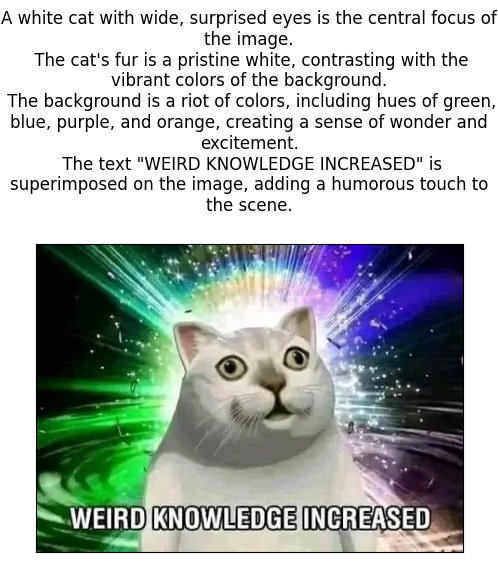

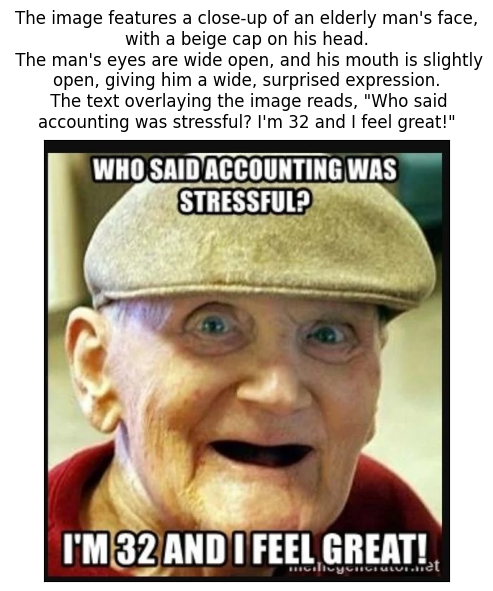

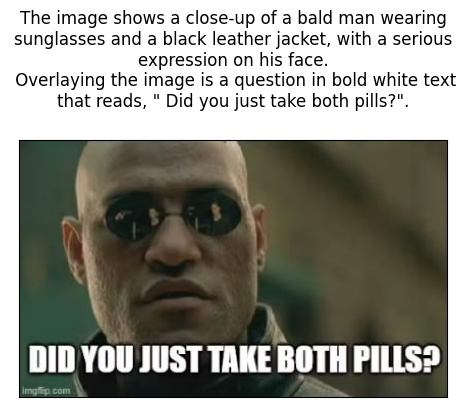

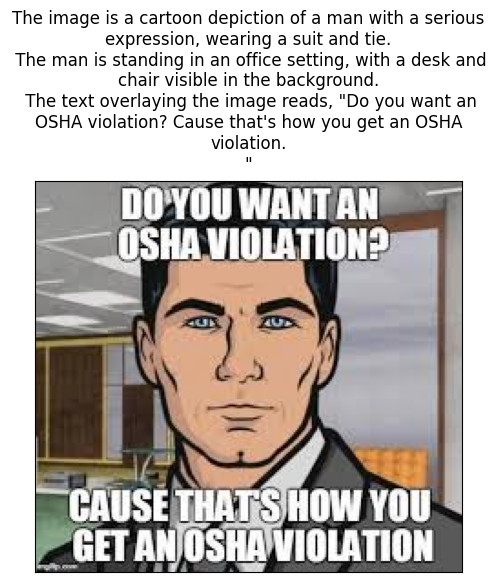

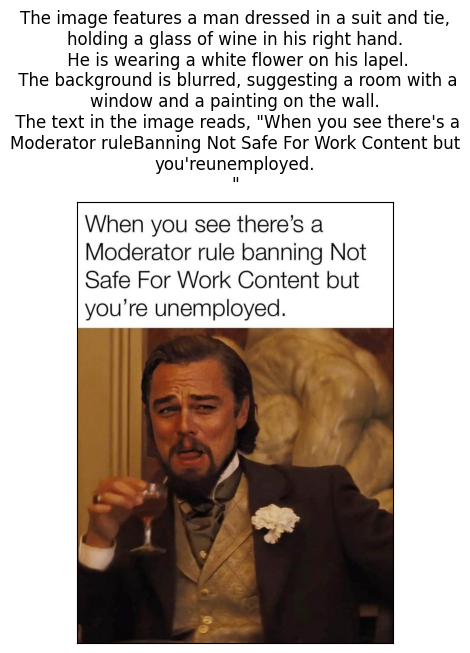

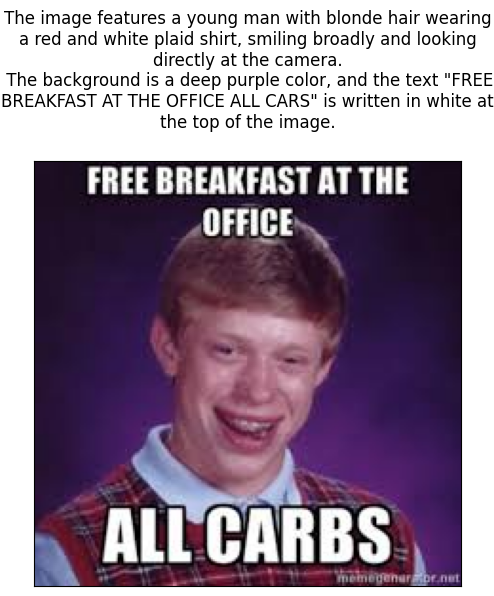

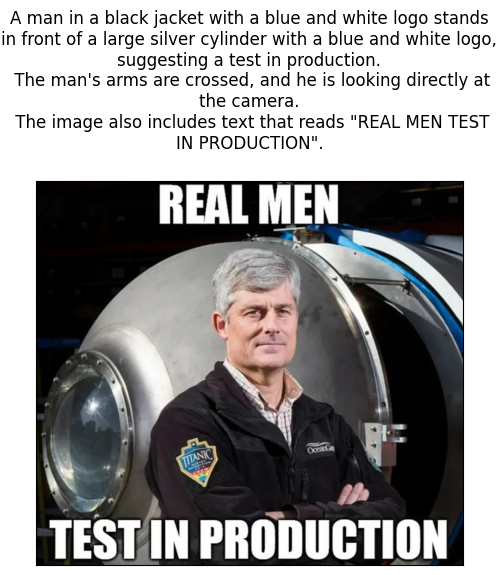

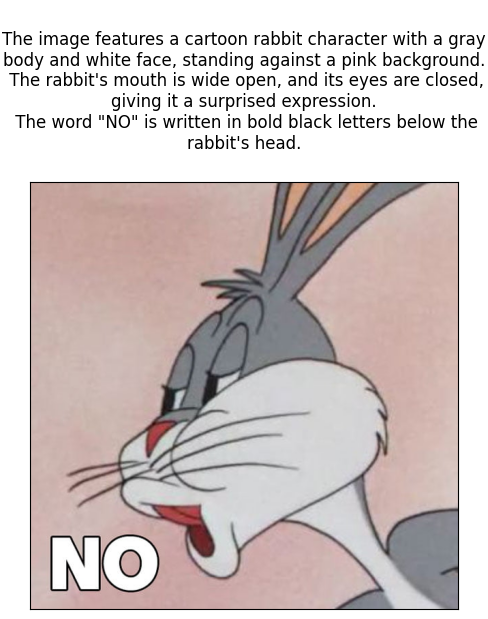

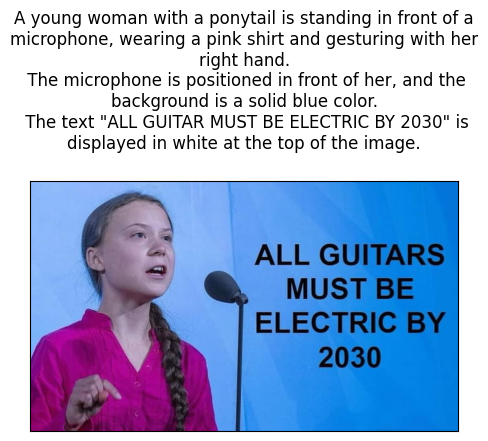

In [3]:
import matplotlib.pyplot as plt

for ind in range(len(img_paths)):
    img_path = img_paths[ind]
    img = Image.open(img_path)
    ans = moondream_answers[ind]
    ans = ".\n".join(ans.split("."))
    fig, sub = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.tight_layout()
    sub.imshow(img)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_title(ans, wrap=True, ha="center", va="bottom")

- side note: if we wanted to just pluck out the text of the memes, the prompt below seems to work fairly well with moondream.

```python
prompt = "What does the text on this image say?  Return only the text you find."
```

# 2.  embed

- using a sliding window we chunk each image's text description into overlapping subwindows of contiguous words.  this helps make the search functionality robust.

- for example, if you wanted to recover the cat image above you might search for it using queries like "weird cat", "green and purple and orange", or "strange knowledge unlocked".

- so by windowing the text description from moondream into a list contiguous overlapping windows we increase the chances that each query will lead back to the image we want.

- below we define a few simple functions to window an image's input text description.

- `clean_word` is a simple regex cleaning function, stripping off non-alphanumeric characters (we won't assume people will search with).

- `chunk_text` takes in the image description, cleans it, and outputs a list of chunks of this text.


- here we'll fix the chunk_size - that is the number of contiguous words in the each window - to 4, and the overlap_size - that is the number of words shared by consecutive windows - to 2.   this can be easily adjusted, but seems reasonable: we're guessing that between 2 - 4 words are typically what will be used to search for a meme.

-  since we might want to search via the meme's text in its entirety (they'll all likely be pretty short) we will include the full text of the meme as well

In [4]:
import re


def clean_word(text: str) -> str:
    # clean input text - keeping only lower case letters, numbers, punctuation, and single quote symbols
    return re.sub(" +", " ", re.compile("[^a-z0-9,.!?']").sub(" ", text.lower().strip()))


def chunk_text(text: str) -> list:
    # split and clean input text
    text_split = clean_word(text).split(" ")
    text_split = [v for v in text_split if len(v) > 0]

    # use two pointers to create chunks
    chunk_size = 4
    overlap_size = 2

    # create next chunk by moving right pointer until chunk_size is reached or line_number changes by more than 1 or end of word_sequence is reached
    left_pointer = 0
    right_pointer = chunk_size - 1
    chunks = []

    if right_pointer >= len(text_split):
        chunks = [" ".join(text_split)]
    else:
        while right_pointer < len(text_split):
            # check if chunk_size has been reached
            # create chunk
            chunk = text_split[left_pointer : right_pointer + 1]

            # move left pointer
            left_pointer += chunk_size - overlap_size

            # move right pointer
            right_pointer += chunk_size - overlap_size

            # store chunk
            chunks.append(" ".join(chunk))

        # check if there is final chunk
        if len(text_split[left_pointer:]) > 0:
            last_chunk = text_split[left_pointer:]
            chunks.append(" ".join(last_chunk))

    # insert the full text
    if len(chunks) > 1:
        chunks.insert(0, text.lower())
    return chunks

- lets see what this algorithm does to an example sentence

"we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description"

In [5]:
# a small test of our chunking algorithm
text = "we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description"
chunks = chunk_text(text)
for chunk in chunks:
    print(chunk)

we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description
we can use moondream's
use moondream's respnose to
respnose to either prompt,
either prompt, or both,
or both, to help
to help us organize
us organize and easily
and easily recall a
recall a meme based
meme based on an
on an input text
input text description


- now we use a text embedding model to transform each chunk into a vector.

- we will use the popular [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model here.

- this transforms each input chunk into a dense vector of length 384 (which is defined by the embedding model).

- below we transform the example chunks above - the function `encode_chunks` is a transparent wrapper on the [sentence_transformers](https://pypi.org/project/sentence-transformers/) library.

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


def encode_chunks(chunks: list) -> np.ndarray:
    return model.encode(chunks)

/Users/jeremywatt/Desktop/content_creation/meme_search/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


- lets encode the chunks from our example sentence above "we can use moondream's respnose to either prompt..."

In [7]:
# test our simple embedding function by embedding chunks above
embeddings = encode_chunks(chunks)
print(embeddings.shape)

(13, 384)


- we had a total of 12 chunks + 1 complete description --> 13 vectors each of length 384.

# 3.  index

- we can now dump our test chunk embeddings into a vector db.

- we will use the open source [faiss database](https://github.com/facebookresearch/faiss).

- faiss is a lightweight vector database that can easily be indexed and queried locally.

- below the `create_vector_db` function takes in a path to save the database, and the embeddings array.  

In [8]:
import numpy as np
import faiss


def create_vector_db(db_file_path: str, embeddings: np.ndarray) -> None:
    # dump all_embeddings to faiss index
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)

    # write index to disk
    faiss.write_index(index, db_file_path)

In [9]:
# test create_vector_db by dumping embeddings and indexing
create_vector_db("test.faiss", embeddings)

- lets try a test query on our newly minted vector db.

- to do this we take an input query in text form and embed it using the same embedder model we used to create the items of the database.

- as an example query we'll use a substring of the original input - "either prompt, or both, to help".

- this will likewise create a dense vector of length 384 (defined by the embedding model).

- notice the query return contains two items: `distances` and `indices`.

- `distances` contains an array of distances in ascending order.

- `indices` contains an array of integer values ordered according to their respective `distances`, from those closest to our input query to those most different from it, and represent the indices of our initial input (`chunks`) above.

- the `query_vector_db` below takes in a text query, the path to our vector db, and (optionally) `k`: the number of similar items to return.

- the query is first embedded before being sent to the vector db, using the same embedding model we used to embed the data.

In [10]:
import faiss
import numpy as np
from typing import Tuple


def query_vector_db(query: str, db_file_path: str, k: int = 5) -> Tuple[list, list]:
    # connect to db
    faiss_index = faiss.read_index(db_file_path)

    # test
    encoded_query = np.expand_dims(model.encode(query), axis=0)

    # query db
    distances, indices = faiss_index.search(encoded_query, k)
    distances = distances.tolist()[0]
    indices = indices.tolist()[0]
    return distances, indices

In [11]:
# map indices back to our initial chunks and print top 5 closest datapoints from chunks
query = "either prompt, or both, to help"
distances, indices = query_vector_db(query, "test.faiss")
query_closest = [chunks[i] for i in indices]
print(f"example_query = '{query}'")
for ind, chunk in enumerate(query_closest):
    print(f"chunk '{chunk}' has distance {round(distances[ind],2)} from example query")

example_query = 'either prompt, or both, to help'
chunk 'either prompt, or both,' has distance 0.18 from example query
chunk 'respnose to either prompt,' has distance 0.39 from example query
chunk 'or both, to help' has distance 1.14 from example query
chunk 'we can use moondream's respnose to either prompt, or both, to help us organize and easily recall a meme based on an input text description' has distance 1.14 from example query
chunk 'input text description' has distance 1.24 from example query


---

 - lets perform the last three steps - chunking, embedding, and vector db creation - with our moondream-extracted text descriptions.

 - we'll make a few convenience functions to help us out.
 
-  the `create_all_img_chunks` takes the image descriptions from moondream and chunks them - just like we did above for the example sentence.

- it outputs a list of dictionaries that includes each image path along with its associated chunk.

- this will let us associate a chunk to its respective image when searching.

In [12]:
# loop over each meme's moondream based text descriptor and create a short dict containing its full and chunked text
def create_all_img_chunks(img_paths: list, answers: list) -> list:
    img_chunks = []
    for ind, img_path in enumerate(img_paths):
        moondream_meme_text = answers[ind]
        moondream_chunks = chunk_text(moondream_meme_text)
        for chunk in moondream_chunks:
            entry = {}
            entry["img_path"] = img_path
            entry["chunk"] = chunk
            img_chunks.append(entry)
    return img_chunks

In [13]:
img_chunks = create_all_img_chunks(img_paths, moondream_answers)
img_chunks[:4]

[{'img_path': 'data/input/test_meme_6.jpg',
  'chunk': 'a white cat with wide, surprised eyes is the central focus of the image. the cat\'s fur is a pristine white, contrasting with the vibrant colors of the background. the background is a riot of colors, including hues of green, blue, purple, and orange, creating a sense of wonder and excitement. the text "weird knowledge increased" is superimposed on the image, adding a humorous touch to the scene.'},
 {'img_path': 'data/input/test_meme_6.jpg', 'chunk': 'a white cat with'},
 {'img_path': 'data/input/test_meme_6.jpg',
  'chunk': 'cat with wide, surprised'},
 {'img_path': 'data/input/test_meme_6.jpg',
  'chunk': 'wide, surprised eyes is'}]

- now only a slight adjustment to the remainder of the embedding / vector db functions above is required.

- we feed in the chunks - stripped off each entry of this list of dictionaries.

- then when querying we can map back to the proper entry.

In [14]:
# embed all chunks
chunks = [v["chunk"] for v in img_chunks]
embeddings = encode_chunks(chunks)

# dump to db
create_vector_db("test.faiss", embeddings)

- now we can query this db, and use the closest matching indices to look up the proper image in `img_chunks`

In [15]:
# query our db
query = "you ate two capsules didn't you"
db_file_path = "test.faiss"
distances, indices = query_vector_db(query, db_file_path)

# map indices back to correct image in img_chunks
img_entries = [img_chunks[i] for i in indices]
for ind, entry in enumerate(img_entries):
    print((entry, f"distance = {round(distances[ind],2)})"))

({'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'both pills? .'}, 'distance = 0.92)')
({'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'just take both pills?'}, 'distance = 0.99)')
({'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'the image shows a close-up of a bald man wearing sunglasses and a black leather jacket, with a serious expression on his face. overlaying the image is a question in bold white text that reads, " did you just take both pills?".'}, 'distance = 1.19)')
({'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'did you just take'}, 'distance = 1.31)')
({'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'that reads, did you'}, 'distance = 1.34)')


- here we can see that most returns belong to the same image.

- for our particular application it would make more sense to just return the top chunk from each distinct image.

- lets query again, choosing a larger number for `k`, to get a few distinct images back.

- we wrap up this and the functionality above into a single function below.

In [16]:
def query_image_chunks(query: str, db_file_path: str, img_chunks: list) -> list:
    # query our db
    distances, indices = query_vector_db(query, db_file_path, k=10)

    # map indices back to correct image in img_chunks
    img_entries = [img_chunks[i] for i in indices]
    imgs_seen = []
    unique_img_entries = []
    for ind, entry in enumerate(img_entries):
        if entry["img_path"] in imgs_seen:
            continue
        else:
            entry["distance"] = round(distances[ind], 2)
            unique_img_entries.append(entry)
            imgs_seen.append(entry["img_path"])
    return unique_img_entries

In [17]:
# test our vector db query function
query = "you ate two capsules didn't you"
db_file_path = "test.faiss"
unique_img_entries = query_image_chunks(query, db_file_path, img_chunks)
print(unique_img_entries)

[{'img_path': 'data/input/test_meme_5.jpg', 'chunk': 'both pills? .', 'distance': 0.92}, {'img_path': 'data/input/test_meme_4.jpg', 'chunk': "that's how you get", 'distance': 1.45}, {'img_path': 'data/input/test_meme_2.jpg', 'chunk': 'with a blue and', 'distance': 1.62}, {'img_path': 'data/input/test_meme_7.jpg', 'chunk': 'and his mouth is', 'distance': 1.63}, {'img_path': 'data/input/test_meme_3.jpg', 'chunk': 'the text free breakfast', 'distance': 1.63}]


- using this setup we can then easily organize and search for our meme's semantically based on their text

# 5. store references connecting the embeddings to their respective images

- reverse look up of indices --> images via our `chunks` data is a perfect use case for a sqlite table.

- sqlite is fast, portable, and very ideal for a use case like this where only one user (you) would be querying such data.

- below we dump the `chunks` data into a sqlite table and index the relevant column = the indices.

- with `chunks` as a sqlite table - as opposed to a list of dictionaries - we never have to load the entire list into memory at once, and lookup will be much faster (instead of scanning for the right row, we'll use the index).

- to do this transfer we will use the `sqlite3` library that comes standard with python.

In [18]:
import sqlite3


def create_sqlite_db(chunks: list, db_filepath: str) -> None:
    # Create a lookup table for chunks
    conn = sqlite3.connect(db_filepath)
    cursor = conn.cursor()

    # Create the table  - delete old table if it exists
    cursor.execute("DROP TABLE IF EXISTS chunks_reverse_lookup")

    # Create the table - alias rowid as chunk_index
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chunks_reverse_lookup (
            chunk_index INTEGER PRIMARY KEY,
            img_path TEXT,
            chunk TEXT
        );
    """)

    # Insert data into the table
    for chunk_index, entry in enumerate(chunks):
        img_path = entry["img_path"]
        chunk = entry["chunk"]
        cursor.execute(
            "INSERT INTO chunks_reverse_lookup (chunk_index, img_path, chunk) VALUES (?, ?, ?)",
            (chunk_index, img_path, chunk),
        )

    conn.commit()
    conn.close()

In [19]:
# build the sqlite lookup table from our img chunks
sqlite_db_path = "test.db"
create_sqlite_db(img_chunks, sqlite_db_path)

- now we can query this database via a list of indices

In [20]:
import sqlite3


def query_sqlite_db(indices: list, db_filepath: str) -> list:
    conn = sqlite3.connect(db_filepath)
    cursor = conn.cursor()
    query = f"SELECT * FROM chunks_reverse_lookup WHERE chunk_index IN {tuple(indices)}"
    cursor.execute(query)
    rows = cursor.fetchall()
    rows = [{"index": row[0], "img_path": row[1], "chunk": row[2]} for row in rows]
    rows = sorted(rows, key=lambda x: indices.index(x["index"]))  # re-sort rows according to input indices
    for row in rows:
        query = f"SELECT * FROM chunks_reverse_lookup WHERE chunk_index=(SELECT MIN(chunk_index) FROM chunks_reverse_lookup WHERE img_path='{row['img_path']}')"
        cursor.execute(query)
        full_description_row = cursor.fetchall()
        row["full_description"] = full_description_row[0][2]
    conn.close()
    return rows

- lets put both vector and sqlite db lookup steps together.
    - first we lookup similar embedding vectors from our vector db after embedding a lookup query.
    - then take the returned indices and lookup the corresponding image(s).

- we will port over some of our final logic above where we did not store chunks as a db - where we kept only unique image file paths.

In [21]:
def complete_query(query: str, vector_db_path: str, sqlite_db_path: str, k: int = 10) -> list:
    # query vector_db, first converting input query to embedding
    distances, indices = query_vector_db(query, vector_db_path, k=k)

    # use indices to query sqlite db containing chunk data
    img_chunks = query_sqlite_db(indices, sqlite_db_path)  # bump up indices by 1 since sqlite row index starts at 1 not 0

    # map indices back to correct image in img_chunks
    imgs_seen = []
    unique_img_entries = []
    for ind, entry in enumerate(img_chunks):
        if entry["img_path"] in imgs_seen:
            continue
        else:
            entry["distance"] = round(distances[ind], 2)
            unique_img_entries.append(entry)
            imgs_seen.append(entry["img_path"])

    # attach full descriptions to each unique image

    return unique_img_entries

In [22]:
# test the complete query function
query = "you ate two capsules didn't you"
vector_db_path = "test.faiss"
sqlite_db_path = "test.db"
complete_query(query, vector_db_path, sqlite_db_path)

[{'index': 83,
  'img_path': 'data/input/test_meme_5.jpg',
  'chunk': 'both pills? .',
  'full_description': 'the image shows a close-up of a bald man wearing sunglasses and a black leather jacket, with a serious expression on his face. overlaying the image is a question in bold white text that reads, " did you just take both pills?".',
  'distance': 0.92},
 {'index': 109,
  'img_path': 'data/input/test_meme_4.jpg',
  'chunk': "that's how you get",
  'full_description': 'the image is a cartoon depiction of a man with a serious expression, wearing a suit and tie. the man is standing in an office setting, with a desk and chair visible in the background. the text overlaying the image reads, "do you want an osha violation? cause that\'s how you get an osha violation."',
  'distance': 1.45},
 {'index': 175,
  'img_path': 'data/input/test_meme_2.jpg',
  'chunk': 'with a blue and',
  'full_description': 'a man in a black jacket with a blue and white logo stands in front of a large silver cyli

# Streamlit app

- the corresponding streamlit app rolls up all of the functionality here into an easy to use app.  see the `README.md` of this repo to play around with it.

- to run the app type the following at your terminal

```python
python -m streamlit run meme_search/app.py
```